In [1]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../../../slayerPytorch/src")

In [2]:
import slayerSNN as snn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dtw import dtw, accelerated_dtw
from numpy.linalg import norm
from joblib import Parallel, delayed
import torch
import copy
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

np.random.seed(1)
torch.manual_seed(1)

In [3]:
#X = np.load('auxiliaries/electrodes.npy')
X = torch.load('../BioTac_Icub_data/Bio_all.pt').permute(0,2,1).numpy()
#Y = np.load('auxiliaries/labels.npy')
Y = np.load('../BioTac_Icub_data/ICUB_all_labels.npy')

In [4]:
X.shape, Y.shape

((1000, 19, 150), (1000,))

In [5]:
def get_ohe(_Y):
    target_class = np.zeros([_Y.shape[0], 20])
    for i in range(target_class.shape[0]):
        target_class[i, int(_Y[i])] = 1
    return target_class

In [6]:
X = X.reshape(X.shape[0], X.shape[1], 1, 1, X.shape[-1])
# Y = Y.reshape(Y.shape[0], Y.shape[1], 1, 1, Y.shape[-1])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42, stratify=Y)

In [8]:
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

target_class_train = torch.FloatTensor(get_ohe(y_train).reshape(-1, 20, 1, 1, 1))
    
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)
target_class_test= torch.FloatTensor(get_ohe(y_test).reshape(-1, 20, 1, 1, 1))


X_train.shape, y_train.shape, target_class_train.shape

(torch.Size([700, 19, 1, 1, 150]),
 torch.Size([700]),
 torch.Size([700, 20, 1, 1, 1]))

In [9]:
params = {
    "neuron": {
        "type": "SRMALPHA",
        "theta": 5, # 10
        "tauSr": 10.0,
        "tauRef": 2.0,
        "scaleRef": 2,
        "tauRho": 1,
        "scaleRho": 1,
    },
    "simulation": {"Ts": 1.0, "tSample": 150, "nSample": 1},
    "training": {
        "error": {
            "type": "NumSpikes",  # "NumSpikes" or "ProbSpikes"
            "probSlidingWin": 20,  # only valid for ProbSpikes
            "tgtSpikeRegion": {  # valid for NumSpikes and ProbSpikes
                "start": 0,
                "stop": 150,
            },
            "tgtSpikeCount": {True: 120, False: 20},
        }
    },
}

params2 = {
    "neuron": {
        "type": "SRMALPHA",
        "theta": 5, # 10
        "tauSr": 10.0,
        "tauRef": 2.0,
        "scaleRef": 2,
        "tauRho": 1,
        "scaleRho": 1,
    },
    "simulation": {"Ts": 1.0, "tSample": 150, "nSample": 1},
    "training": {
        "error": {
            "type": "SpikeTime",  # "NumSpikes" or "ProbSpikes"
            "probSlidingWin": 20,  # only valid for ProbSpikes
            "tgtSpikeRegion": {  # valid for NumSpikes and ProbSpikes
                "start": 0,
                "stop": 150,
            },
            "tgtSpikeCount": {True: 120, False: 20},
        }
    },
}

In [10]:
train_dataset = torch.utils.data.TensorDataset(X_train, target_class_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=8)

test_dataset = torch.utils.data.TensorDataset(X_test, target_class_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset,shuffle=True,batch_size=8)

In [11]:
class SlayerMLP(torch.nn.Module):
    def __init__(self, params, input_size, hidden_size1, hidden_size2, output_size):
        super(SlayerMLP, self).__init__()
        self.output_size = output_size
        self.slayer = snn.layer(params["neuron"], params["simulation"])
        self.fc1 = self.slayer.dense(input_size, hidden_size1)
        self.fc2 = self.slayer.dense(hidden_size1, hidden_size2)
        self.fc3 = self.slayer.dense(hidden_size2, output_size)
        
        self.fc_decoder1 = self.slayer.dense(hidden_size2, 30)
        self.fc_decoder2 = self.slayer.dense(30, input_size)

    def get_spike(self, inp):
        return self.slayer.spike(inp)
    
    def forward(self, spike_input):
        spike_1 = self.slayer.spike(self.slayer.psp(self.fc1(spike_input)))
        spike_2 = self.slayer.spike(self.slayer.psp(self.fc2(spike_1)))
        spike_output = self.slayer.spike(self.slayer.psp(self.fc3(spike_2)))
        
        spike_hat1 = self.slayer.spike(self.slayer.psp(self.fc_decoder1(spike_2)))
        spike_hat2 = self.slayer.spike(self.slayer.psp(self.fc_decoder2(spike_hat1)))
        
        return spike_output, spike_hat2, spike_2, spike_hat1

In [12]:
device = torch.device("cuda:1")
net = SlayerMLP(params, 19, 50, 50, 20).to(device)

In [13]:
error = snn.loss(params).to(device)
error2 = snn.loss(params2).to(device)
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001, weight_decay=0.5)

In [14]:
148/len(train_dataset)

0.21142857142857144

In [15]:
train_total_losses=[]
train_class_losses=[]
train_regres_losses=[]

test_total_losses=[]
test_class_losses=[]
test_regres_losses=[]

train_accs = []
test_accs = []

alpha = 1
beta = 0.001
for epoch in range(601):
    net.train()
    correct = 0
    loss_train = 0
    loss_class = 0
    loss_reg = 0
    for i, (tact, target, label) in enumerate(train_loader):
        
        tact = tact.to(device)
        target = target.to(device)
        tact = net.get_spike(tact)
        output, out_input, _, _ = net.forward(tact)
        
        correct += torch.sum(snn.predict.getClass(output) == label).data.item()
        loss_class = error.numSpikes(output, target)
        
        loss_reg = error2.spikeTime(out_input, tact)
        
        loss = alpha*loss_class + beta*loss_reg
        
        loss_train += loss.item()
        loss_class = alpha*loss_class.item()
        loss_reg = beta*loss_reg.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
    if epoch%10 == 0:
        print('Epoch: ', epoch, ' --------------------------')
        print('Train loss (all, class, reg):', 
              loss_train/len(train_dataset),
              loss_class/len(train_dataset),
              loss_reg/len(train_dataset))
        print('Train accuracy:', correct/len(train_dataset))
    train_accs.append(correct/len(train_dataset))
    train_total_losses.append(loss_train/len(train_dataset))
    train_class_losses.append(loss_class/len(train_dataset))
    train_regres_losses.append(loss_reg/len(train_dataset))
        
    net.eval()
    correct = 0
    loss_test = 0
    loss_class = 0
    loss_reg = 0
    with torch.no_grad():
        for i, (tact, target, label) in enumerate(test_loader):

            tact = tact.to(device)
            target = target.to(device)
            tact = net.get_spike(tact)
            output, out_input, _, _ = net.forward(tact)
        
            correct += torch.sum(snn.predict.getClass(output) == label).data.item()
            loss_class = error.numSpikes(output, target)

            loss_reg = error2.spikeTime(out_input, tact)

            loss = alpha*loss_class + beta*loss_reg

            loss_test += loss.item()
            loss_class = alpha*loss_class.item()
            loss_reg = beta*loss_reg.item()
            
#     if epoch%10 == 0:
#         print('Test loss:', loss_test/len(test_dataset))
#         print('Test accuracy:', correct/len(test_dataset))
#     test_accs.append(correct/len(test_dataset))
#     test_losses.append(loss_test/len(test_dataset))
    
    if epoch%10 == 0:
        print('Test loss (all, class, reg):', 
              loss_test/len(test_dataset),
              loss_class/len(test_dataset),
              loss_reg/len(test_dataset))
        print('Test accuracy:', correct/len(test_dataset))
    test_accs.append(correct/len(test_dataset))
    test_total_losses.append(loss_test/len(test_dataset))
    test_class_losses.append(loss_class/len(test_dataset))
    test_regres_losses.append(loss_reg/len(test_dataset))

Epoch:  0  --------------------------
Train loss (all, class, reg): 170.79375645228794 0.23354762486049108 0.32411513392857144
Train accuracy: 0.08571428571428572
Test loss (all, class, reg): 102.69784973144532 0.7054444376627604 0.6978919270833334
Test accuracy: 0.23
Epoch:  10  --------------------------
Train loss (all, class, reg): 40.06904813494001 0.11539999825613839 0.077207265625
Train accuracy: 0.5828571428571429
Test loss (all, class, reg): 39.16887776692708 0.2728666687011719 0.18392854166666667
Test accuracy: 0.6266666666666667
Epoch:  20  --------------------------
Train loss (all, class, reg): 32.87057074410575 0.14208095005580357 0.058964252232142855
Train accuracy: 0.7171428571428572
Test loss (all, class, reg): 33.44564465840658 0.24432220458984374 0.154351875
Test accuracy: 0.71
Epoch:  30  --------------------------
Train loss (all, class, reg): 29.07142083304269 0.11075714111328125 0.05986929129464285
Train accuracy: 0.7728571428571429
Test loss (all, class, reg): 2

Epoch:  300  --------------------------
Train loss (all, class, reg): 14.926673409598214 0.06392857142857143 0.05692125558035715
Train accuracy: 0.9371428571428572
Test loss (all, class, reg): 15.955829315185547 0.21418889363606772 0.08943447265625
Test accuracy: 0.9266666666666666
Epoch:  310  --------------------------
Train loss (all, class, reg): 14.778192836216517 0.06528094700404576 0.03258657366071429
Train accuracy: 0.9514285714285714
Test loss (all, class, reg): 15.833977686564127 0.10151110967000325 0.11553834635416665
Test accuracy: 0.9166666666666666
Epoch:  320  --------------------------
Train loss (all, class, reg): 14.679087764195033 0.0721904809134347 0.07516922433035715
Train accuracy: 0.9485714285714286
Test loss (all, class, reg): 15.893698450724283 0.095977783203125 0.08458434895833333
Test accuracy: 0.92
Epoch:  330  --------------------------
Train loss (all, class, reg): 14.545642073495047 0.021766666684831893 0.06893265625
Train accuracy: 0.9485714285714286
Tes

Epoch:  600  --------------------------
Train loss (all, class, reg): 11.924446819850377 0.016238095419747488 0.044045725446428576
Train accuracy: 0.9671428571428572
Test loss (all, class, reg): 13.403640200297037 0.05196666717529297 0.084695
Test accuracy: 0.95


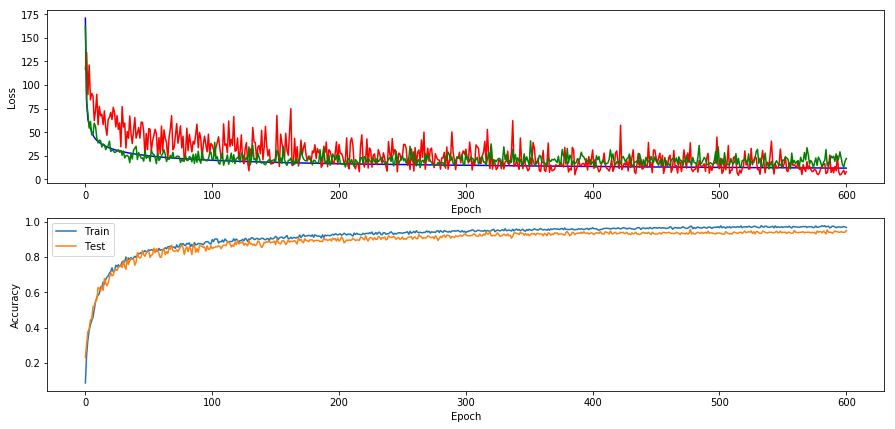

In [16]:
fig, ax = plt.subplots(2, figsize=(15,7))

ax[0].plot(train_total_losses, 'b')
ax[0].plot(500*np.array(train_class_losses), 'r')
ax[0].plot(500*np.array(train_regres_losses), 'g')

# ax[0].plot(test_losses)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(train_accs)
ax[1].plot(test_accs)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend(['Train', 'Test'])

plt.show()

In [17]:
np.max(test_accs)

0.9566666666666667

In [18]:
np.max(train_accs)

0.9771428571428571

In [19]:
net.eval()
big_list = []
label_list=[]
with torch.no_grad():
    for i, (tact, target, label) in enumerate(test_loader):

        tact = tact.to(device)
        target = target.to(device)
        tact = net.get_spike(tact)
        _, _, rep, _ = net.forward(tact)
        big_list.append(rep)
        label_list.append(label)

In [20]:
test_representation = torch.cat(big_list,0)
test_representation.shape

torch.Size([300, 50, 1, 1, 150])

In [21]:
label_all = torch.cat(label_list, 0)

In [22]:
label_all = label_all.cpu().numpy()

In [23]:
%%time
dist_mat = torch.zeros([300,300])
for i in range(300):
    for j in range(300):
        if i == j:
            dist_mat[i, j] = 0.0
        else:
            dist_mat[i,j] = error2.spikeTime(test_representation[i], test_representation[j])

CPU times: user 10.9 s, sys: 148 ms, total: 11 s
Wall time: 11 s


In [24]:
dist_mat = dist_mat.detach().cpu().numpy()

In [25]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2,perplexity=10, metric='precomputed').fit_transform(dist_mat)

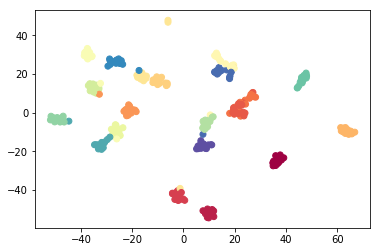

In [26]:
fig, ax = plt.subplots()
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=label_all, cmap=plt.cm.Spectral)
plt.show()